In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import pymc3 as pm
from pymc3 import  *
import math
import numpy as np
import matplotlib.pyplot as plt
import theano


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\david\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Simulating noisy linear data

size = 20
true_intercept = 2
true_slope = 3

#create x colums
x1 = np.linspace(0, 1, size, endpoint=True)
x1 = np.random.RandomState(42).choice(x1, len(x1))
dataset = pd.DataFrame(x1, columns=['x'])

#create y colums
true_regression_line = true_intercept + true_slope * dataset['x']

dataset['y'] = true_regression_line + np.random.RandomState(42).normal(0, math.sqrt(2))

print("Dataset: ")
print(dataset)

Dataset: 
           x         y
0   0.315789  3.649828
1   1.000000  5.702460
2   0.736842  4.912986
3   0.526316  4.281407
4   0.368421  3.807723
5   0.315789  3.649828
6   0.947368  5.544565
7   0.526316  4.281407
8   0.526316  4.281407
9   0.157895  3.176144
10  0.368421  3.807723
11  0.105263  3.018249
12  0.052632  2.860355
13  0.578947  4.439302
14  0.263158  3.491934
15  0.052632  2.860355
16  0.000000  2.702460
17  0.578947  4.439302
18  0.578947  4.439302
19  0.842105  5.228776


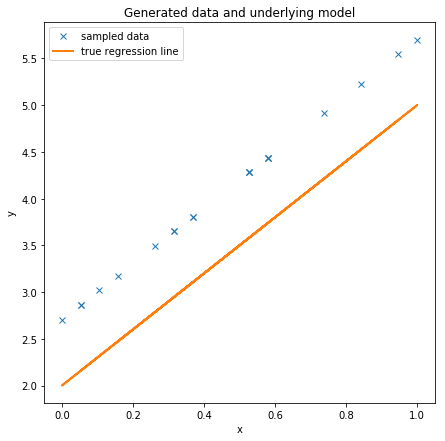

In [3]:
x=dataset['x']
y=dataset['y']

data = dict(x=x, y=y)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);


In [4]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    
    family = pm.glm.families.Normal()
    
    glm.GLM.from_formula('y ~ x', data, family=family)

    # Inference!
    trace = sample(draws=5000, step=pm.step_methods.hmc.nuts.NUTS(), start=pm.find_MAP(), random_seed=42, progressbar=True)


C:\Users\david\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -147.33, ||grad|| = 5.9453e+08: 100%|██████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 411.97it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████████████████████████| 11000/11000 [03:08<00:00, 58.47draws/s]
There were 2786 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.020948660099425993, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2

<Figure size 504x504 with 0 Axes>

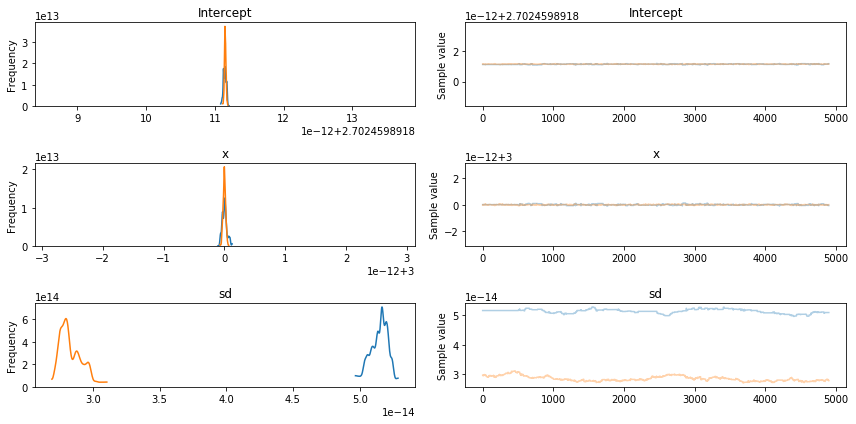

In [5]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();


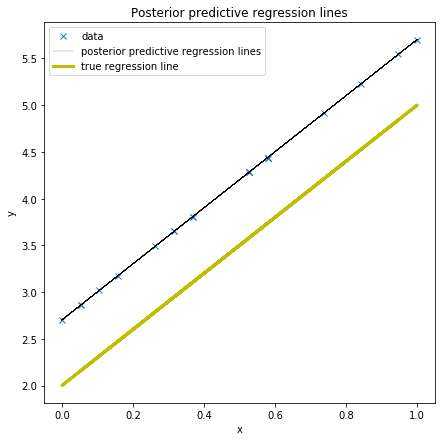

In [6]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plot_posterior_predictive_glm(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');


In [7]:
'''Compare the values:

Beta1 = 2
Beta2 = 3
Epsilon = 0.70246

mean column -> the mean of x is EXACTLY the value of Beta2 (true_slope) and the intercept is
    EXACTLY Beta1 (true_intercept) + the noise (this makes actually sense)
'''

stats.summary(trace)

mean            sd      mc_error       hpd_2.5  \
Intercept  2.702460e+00  1.740977e-14  1.071682e-15  2.702460e+00   
x          3.000000e+00  3.253627e-14  1.875035e-15  3.000000e+00   
sd         3.992443e-14  1.153288e-14  1.153097e-15  2.741853e-14   

               hpd_97.5       n_eff       Rhat  
Intercept  2.702460e+00   60.920502   1.032248  
x          3.000000e+00  244.608228   1.002885  
sd         5.245697e-14    1.003358  21.196240

In [8]:
#ROBUST REGRESSION

with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(draws=5000, step=pm.step_methods.hmc.nuts.NUTS(), start=pm.find_MAP(), random_seed=42, progressbar=True)


logp = -255.12, ||grad|| = 184.16: 100%|██████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 203.61it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████████████████████████| 11000/11000 [08:32<00:00, 21.48draws/s]
The acceptance probability does not match the target. It is 0.09056668767800681, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.07478017427600618, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


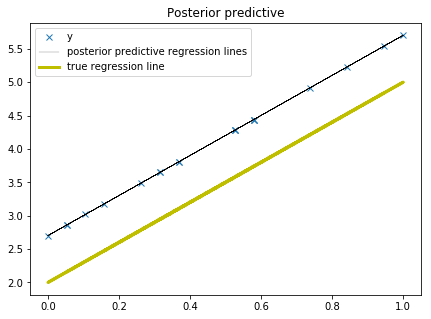

In [9]:
#plot the result

plt.figure(figsize=(7, 5))
plt.plot(x, y, 'x')
pm.plot_posterior_predictive_glm(trace_robust,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
         label='true regression line', lw=3., c='y')
plt.legend();

In [10]:
stats.summary(trace)

mean            sd      mc_error       hpd_2.5  \
Intercept  2.702460e+00  1.740977e-14  1.071682e-15  2.702460e+00   
x          3.000000e+00  3.253627e-14  1.875035e-15  3.000000e+00   
sd         3.992443e-14  1.153288e-14  1.153097e-15  2.741853e-14   

               hpd_97.5       n_eff       Rhat  
Intercept  2.702460e+00   60.920502   1.032248  
x          3.000000e+00  244.608228   1.002885  
sd         5.245697e-14    1.003358  21.196240